アドバイスしてもらったった

* そもそもなんで間違っていたの？ 精度が落ちているの？
    * 間違っているところの特徴をplotしてみよう
    * その特徴にきく変数を用意してみよう
* 変数によっては下げる要因になる場合もある（ノイズ）
* 間違ったものだけでモデルを作成する方法もあり
    * outputされた結果を最後ガッチャンコする必要がある

さらに＋な情報

試しにkaggleにオール0とオール1で投げてみたらこんな感じ

* 全員生存: 0.37321  
* 全員死亡: 0.62679

そもそも、生存の比率は小さいので、作成したモデルがそこにいたっていなきゃ間違いということになる。  
それを踏まえた上で良いモデルを作る。

In [2]:
# いつも使うやつ
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import interp
import seaborn as sns

# pandasで全ての列を表示
pd.options.display.max_columns = None

# 図をipython notebook内で表示
%matplotlib inline

# DeplicatedWarningを避けるため
import warnings
#warnings.filterwarnings("ignore", category=DeprecationWarning)

import sys
sys.path.append('./lib/')

# 交差検定をサクッとやるためのモジュールを読み込む
from sklearn.cross_validation import cross_val_score

# 説明変数つくるための関数
import feature_process_helper
import get_data
import learn

# submissionを書き込む関数
import write_submission

/Users/k.tamashiro/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/k.tamashiro/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [329]:
# データをそれぞれ読み込む
train_df, test_df, submission_df = get_data.get(path='./data')
train = train_df.copy()
test = test_df.copy()

In [330]:
train, test = feature_process_helper.names(train, test)
train, test = feature_process_helper.age_impute(train, test)
train, test = feature_process_helper.dummies(train, test, columns=['Pclass', 'Sex', 'Embarked'])
trian, test = feature_process_helper.family_size_int(train, test)
# train, test = feature_process_helper.drop(train, test, bye=['SibSp', 'Parch', 'Ticket', 'Cabin', 'Name_Title', 'Pclass_3', 'Sex_male', 'Embarked_Q'])
test['Fare'].fillna(train['Fare'].mean(), inplace = True)

In [165]:
x_train = train[['Sex_female', 'Fare', 'Age']]
x_test = test[['Sex_female', 'Fare', 'Age']]
y_train = train['Survived']

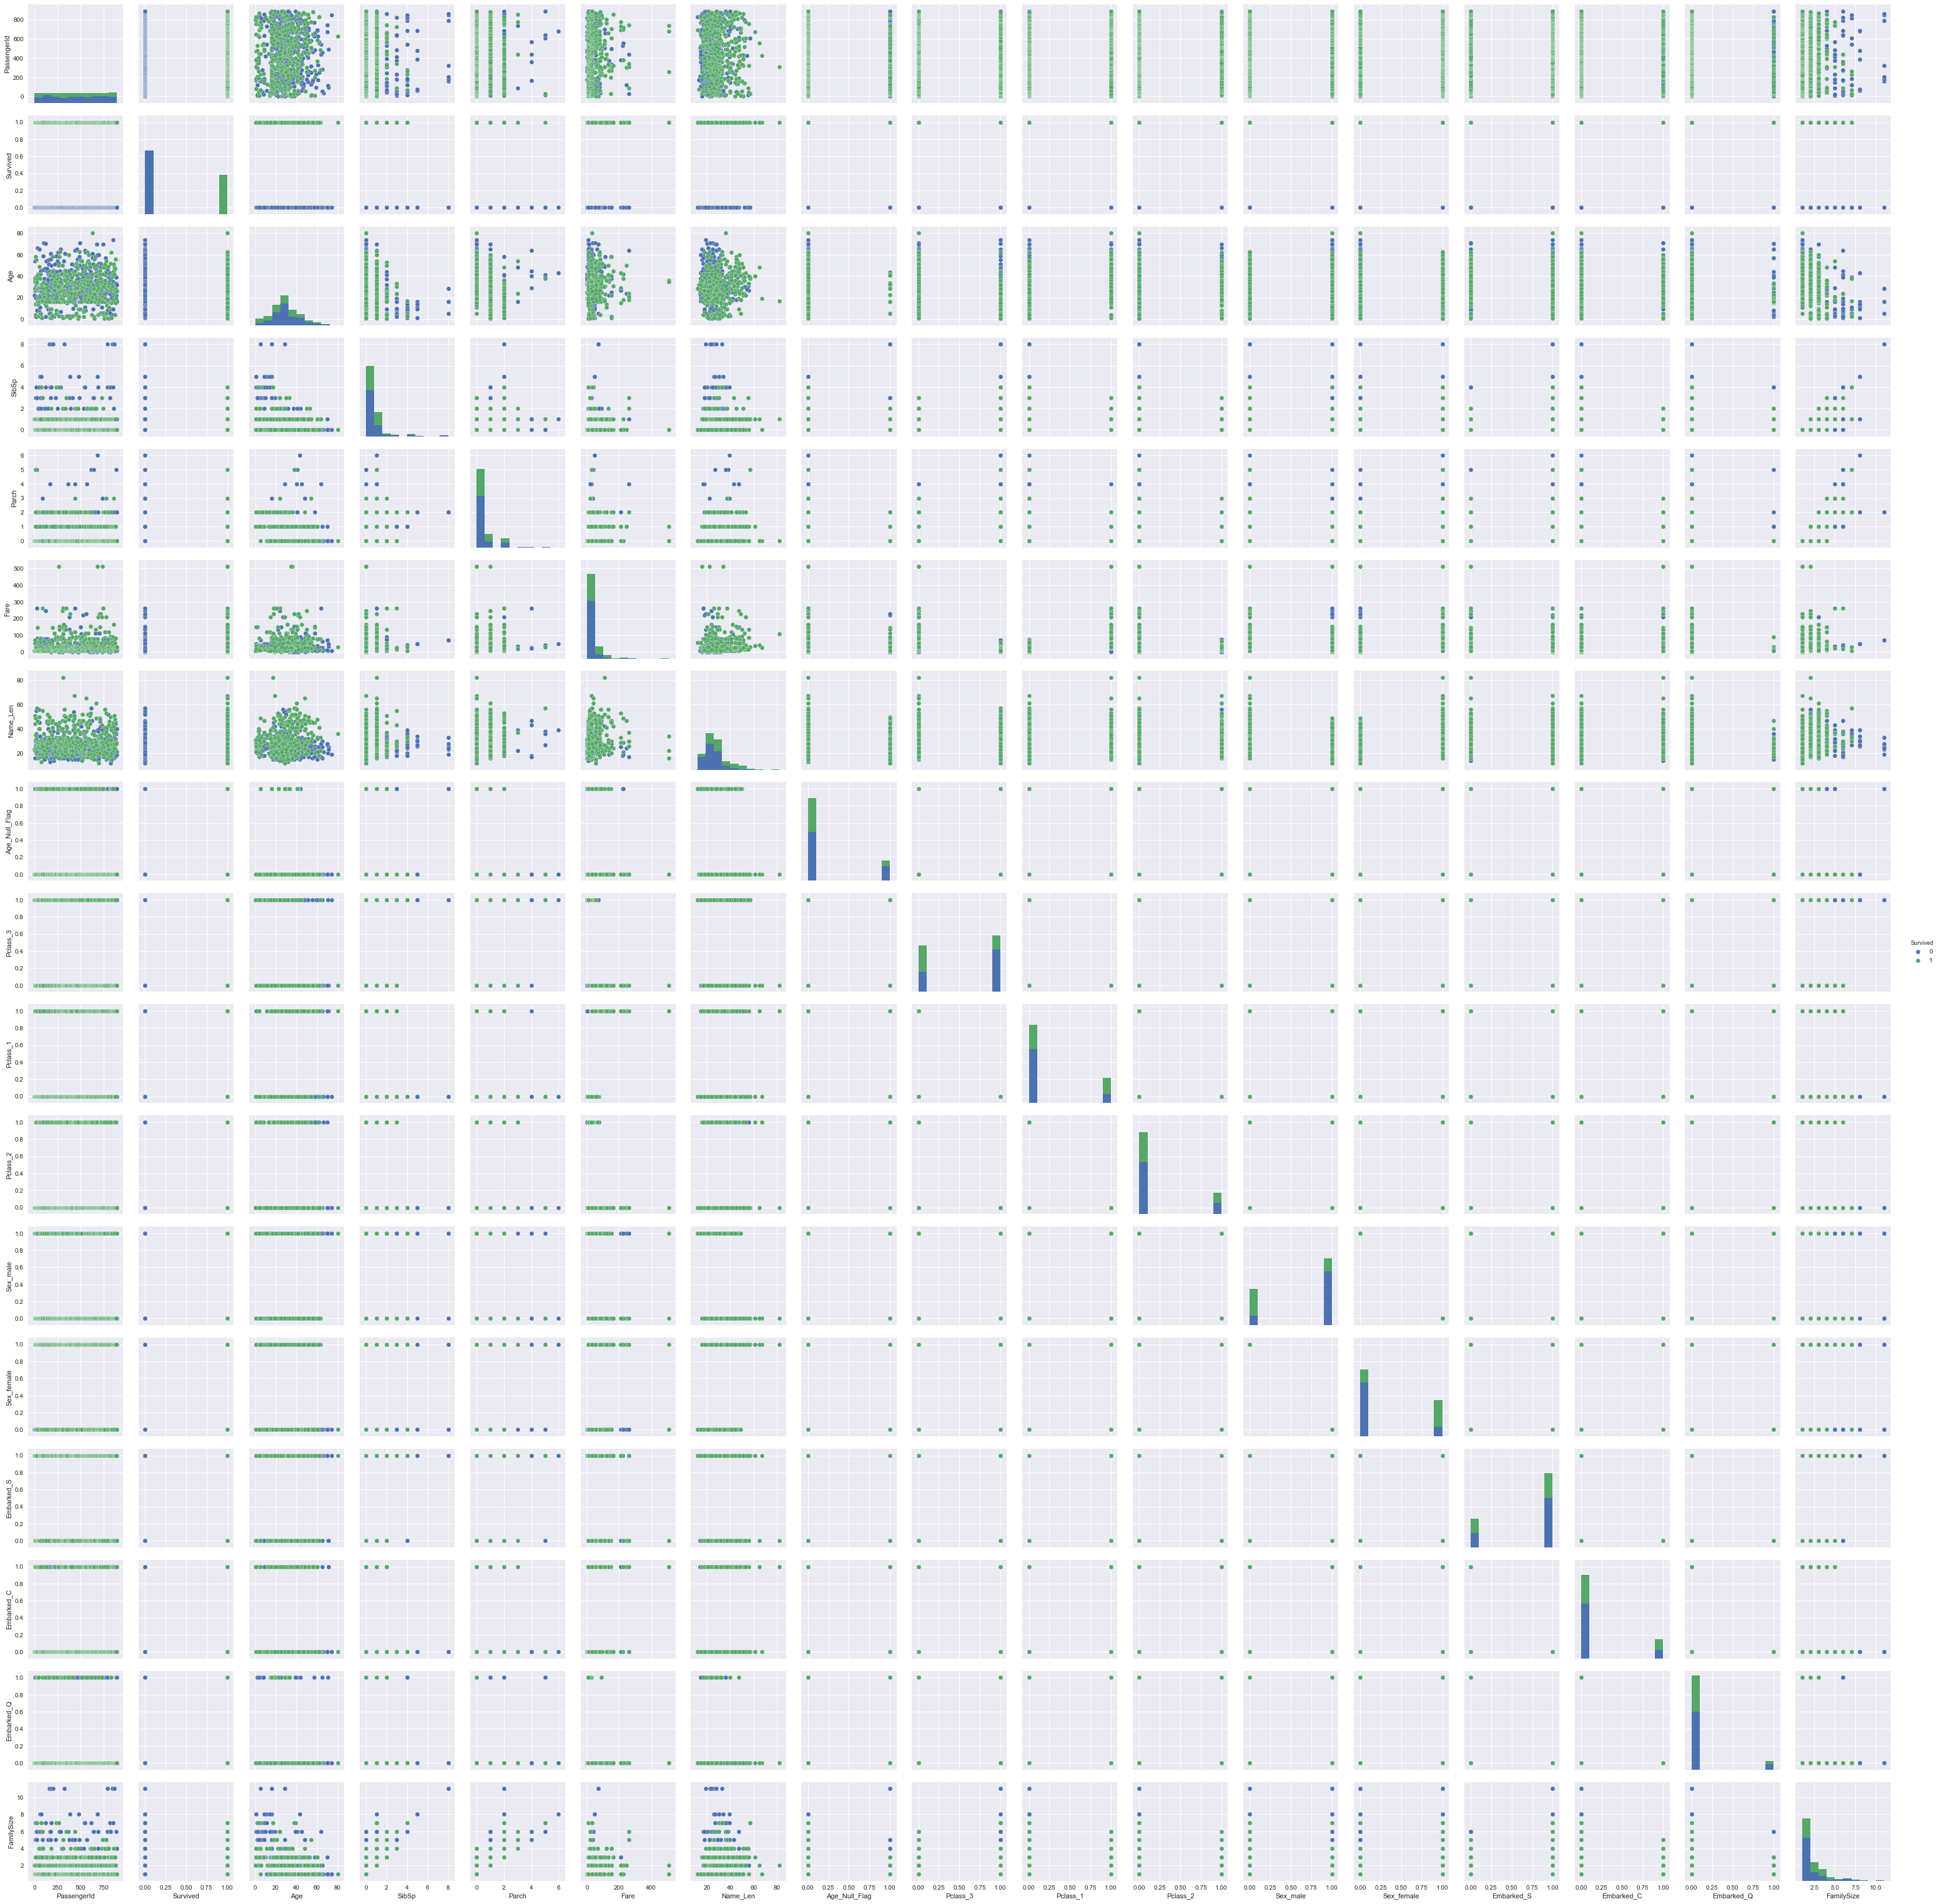

In [332]:
sns.pairplot(train, hue='Survived')

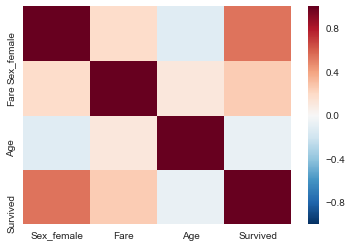

In [166]:
sns.heatmap(train[['Sex_female', 'Fare', 'Age', 'Survived']].corr())

In [6]:
search = learn.search(x_train, y_train)
model = learn.learn(x_train, y_train, parameter=search.best_params_)

In [38]:
search.best_params_

{'criterion': 'entropy',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 100}

In [28]:
y_train[y_train == model.predict(x_train)].count() / len(y_train)

0.91245791245791241

In [36]:
submission_df.loc[submission_df['Survived'] == model.predict(x_test), 'Survived'].count() / len(submission_df)

0.88277511961722488

In [193]:
cv_scores = cross_val_score(model, x_train, y_train, cv=10, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(cv_scores), np.std(cv_scores)))

CV accuracy: 0.809 +/- 0.038


In [198]:
cv_scores.mean()

0.80923334468278285

In [ ]:
model.predict(x_train)

In [294]:
# 二値分類をやる
pre_core_df = pd.DataFrame({'correct': y_train, 'predict':  model.predict(x_train)})

len(pre_core_df)

891

In [321]:
# 正解した結果
# 正解だった
_all_correct = pre_core_df[pre_core_df['correct'] == pre_core_df['predict']]['predict'].count()
# 正解で生存していたを当てた
_correct_survival = pre_core_df[(pre_core_df['correct'] == pre_core_df['predict']) & (1 == pre_core_df['predict'])]['predict'].count()
# 正解で死亡を当てた
_correct_dead = pre_core_df[(pre_core_df['correct'] == pre_core_df['predict']) & (0 == pre_core_df['predict'])]['predict'].count()
# 生存と予測したけど、死亡してた
_unexpected = pre_core_df[(pre_core_df['correct'] != pre_core_df['predict']) & (0 != pre_core_df['predict'])]['predict'].count()
# 死亡と予測したけど、生存してた
_missing = pre_core_df[(pre_core_df['correct'] != pre_core_df['predict']) & (1 != pre_core_df['predict'])]['predict'].count()

In [322]:
print('正解: %d' % _all_correct)
print('正解で生存を当てた: %d' % _correct_survival)
print('正解で死亡を当てた: %d' % _correct_dead)
print('予期しない: %d' % _unexpected)
print('欠落した: %d'% _missing)
print('間違い: %d' % (_unexpected + _missing))

正解: 784
正解で生存を当てた: 273
正解で死亡を当てた: 511
予期しない: 38
欠落した: 69
間違い: 107


* 取りこぼしがあるが、結果に誤りがない => 「precision（適合率が高い）」  => 結果の中にどれくらい正解が多いか
* 結果に誤りがあるが、取りこぼしはない => 「recall（再現率が高い）」 => 正解のうちどの程度が検索にヒットするか
* F値 = （2×適合率×再現率）/（適合率＋再現率）

In [323]:
# 関数があった
from sklearn.metrics import confusion_matrix
confusion_matrix(pre_core_df['correct'], pre_core_df['predict'])

array([[511,  38],
       [ 69, 273]])

In [326]:
from sklearn import metrics
# 適合率、再現率、F-値(F-measure)
print('適合率: %f' % metrics.precision_score(pre_core_df['correct'], pre_core_df['predict']))
print('再現率: %f' % metrics.recall_score(pre_core_df['correct'], pre_core_df['predict']))
print('F値: %f' % metrics.f1_score(pre_core_df['correct'], pre_core_df['predict']))

適合率: 0.877814
再現率: 0.798246
F値: 0.836141


In [110]:
from sklearn.cross_validation import StratifiedKFold
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [5, 6]])
y = np.array([0, 0, 1, 1, 0])
skf = StratifiedKFold(y, n_folds=2)
for train_index, test_index in skf:
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [3 4] TEST: [0 1 2]
TRAIN: [0 1 2] TEST: [3 4]


仮説立て

* 生存と死亡の率は偏ってそうなので、死亡率が高い変数を探すのもあり？
* カテゴリカルなデータが多いので、前処理しながらクロス集計で生存率を見てみる
    * 決定木ってクロス集計のループ版っぽいので、それで確認するのもあり（かも）
* 一個作ったモデルでスコアの正答率を見る
    * スコア
        * 正解で生存を当てた: 273
        * 正解で死亡を当てた: 511
        * 予期しない(予測0で1だった): 38
        * 欠落した(予測1で0だった): 69
        * 間違い: 107
    * 上記それぞれを単位あわせて比較して、変数の差分を確認してみる
* お金持ちは生存しやすい？
* 部屋によっては生存と死亡率がある？
* 家族がいないと優先されなかったとか、家族が多いと死亡率が逆に上がったりする？
    * 女性の家族がいると優先されるから生存率があがる？
* 子供は優先されたから年齢が低いほうが生存率あがる？

In [3]:
# データをそれぞれ読み込む
train_df, test_df, submission_df = get_data.get(path='./data')
train = train_df.copy()
test = test_df.copy()

train, test = feature_process_helper.names(train, test)
train, test = feature_process_helper.age_impute(train, test)
train, test = feature_process_helper.cabin_num(train, test)
train, test = feature_process_helper.cabin(train, test)
train, test = feature_process_helper.embarked_impute(train, test)
train, test = feature_process_helper.fam_size(train, test)
train['Ticket_Len'] = train['Ticket'].apply(lambda x: len(x))
test['Ticket_Len'] = test['Ticket'].apply(lambda x: len(x))
train, test = feature_process_helper.dummies(train, test, columns = ['Pclass', 'Sex', 'Embarked',
                                                                     'Cabin_Letter', 'Name_Title', 'Fam_Size'])
train, test = feature_process_helper.drop(train, test, bye = ['Ticket'])

test['Fare'].fillna(train['Fare'].mean(), inplace = True)

In [6]:
train.columns

Index(['PassengerId', 'Survived', 'Age', 'SibSp', 'Parch', 'Fare', 'Name_Len',
       'Age_Null_Flag', 'Cabin_num_[2, 28.667]', 'Cabin_num_(28.667, 65.667]',
       'Cabin_num_(65.667, 148]', 'Ticket_Len', 'Pclass_3', 'Pclass_1',
       'Pclass_2', 'Sex_male', 'Sex_female', 'Embarked_S', 'Embarked_C',
       'Embarked_Q', 'Cabin_Letter_n', 'Cabin_Letter_C', 'Cabin_Letter_E',
       'Cabin_Letter_G', 'Cabin_Letter_D', 'Cabin_Letter_A', 'Cabin_Letter_B',
       'Cabin_Letter_F', 'Name_Title_Mr.', 'Name_Title_Mrs.',
       'Name_Title_Miss.', 'Name_Title_Master.', 'Name_Title_Rev.',
       'Name_Title_Dr.', 'Name_Title_Ms.', 'Name_Title_Col.',
       'Fam_Size_Nuclear', 'Fam_Size_Solo', 'Fam_Size_Big'],
      dtype='object')

In [32]:
target_parameter = ['Age', 'SibSp', 'Parch', 'Fare', 'Pclass_3', 'Pclass_1', 'Sex_male', 'Embarked_C', 'Embarked_Q']

In [35]:
# 決定木で効いてそうなのを確認する
from sklearn import tree

tree_model = tree.DecisionTreeClassifier(max_depth=5)
tree_model.fit(train.loc[:, target_parameter], train.iloc[:, 1])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

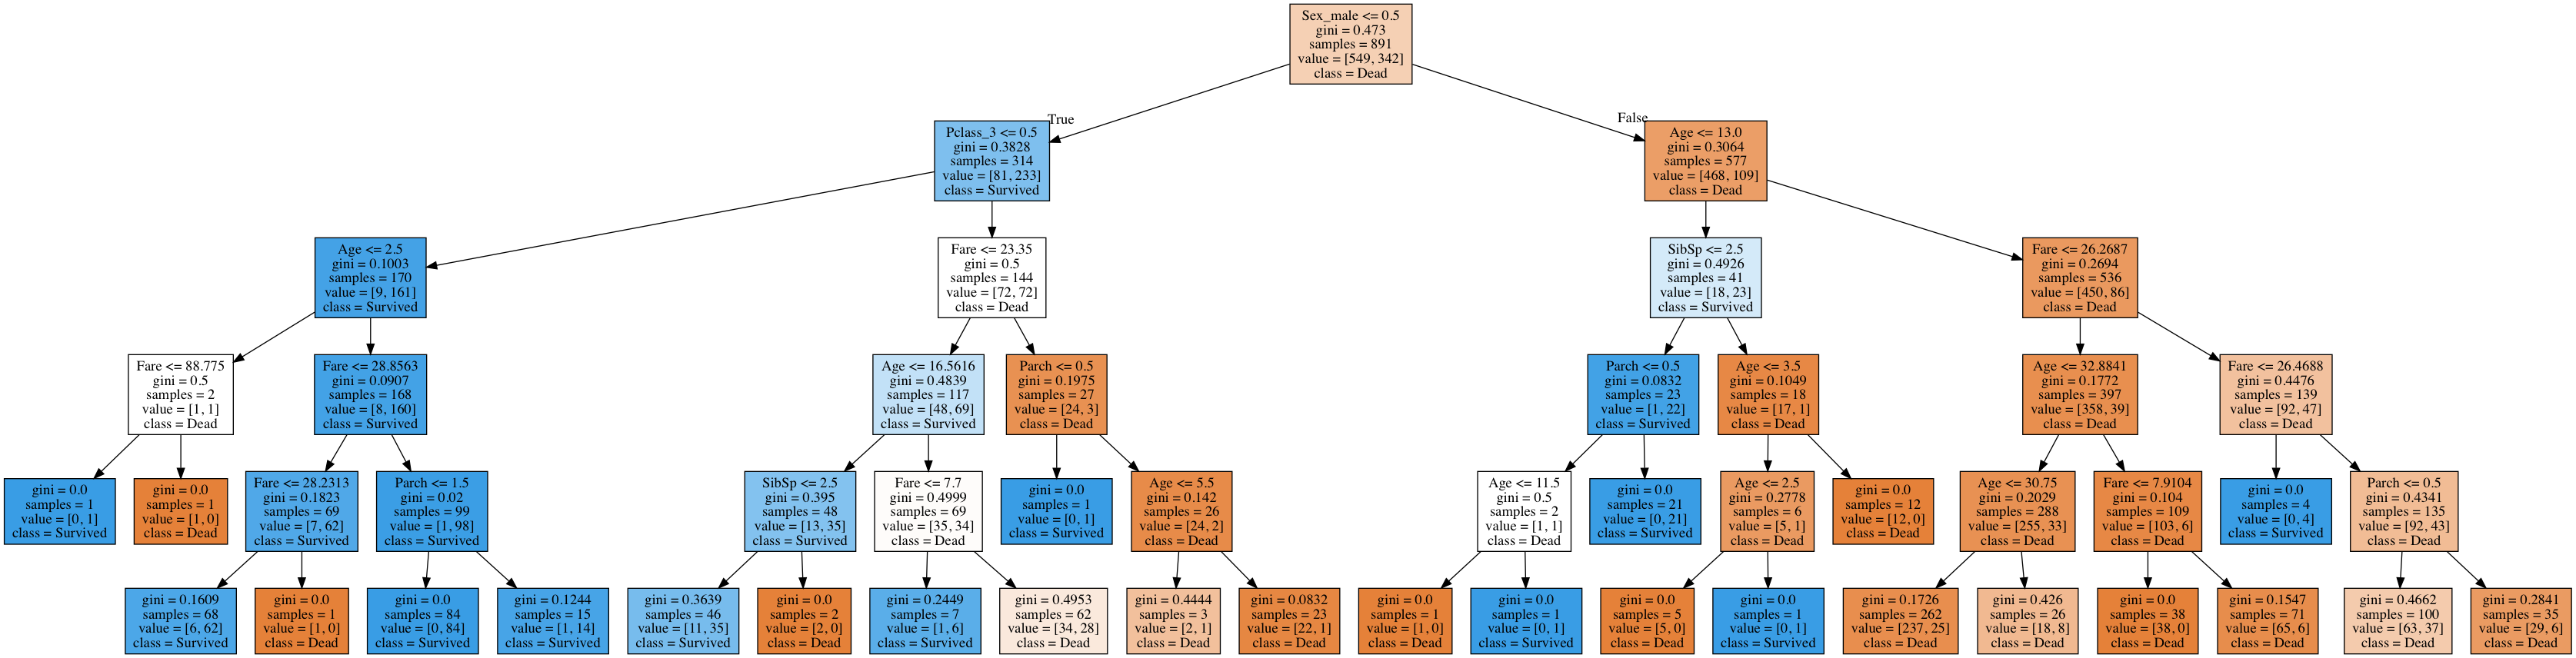

In [42]:
from IPython.display import Image
import pydotplus
from sklearn.externals.six import StringIO
dot_data = StringIO()
tree.export_graphviz(tree_model, out_file=dot_data, feature_names=target_parameter, class_names=['Dead', 'Survived'], filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [43]:
from sklearn.metrics import confusion_matrix
confusion_matrix(train.iloc[:, 1], tree_model.predict(train.loc[:, target_parameter]))

array([[530,  19],
       [112, 230]])

In [44]:
cv_scores = cross_val_score(tree_model, train.loc[:, target_parameter], train.iloc[:, 1], cv=10, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(cv_scores), np.std(cv_scores)))

CV accuracy: 0.806 +/- 0.040


In [45]:
from sklearn import metrics
# 適合率、再現率、F-値(F-measure)
print('適合率: %f' % metrics.precision_score(train.iloc[:, 1], tree_model.predict(train.loc[:, target_parameter])))
print('再現率: %f' % metrics.recall_score(train.iloc[:, 1], tree_model.predict(train.loc[:, target_parameter])))
print('F値: %f' % metrics.f1_score(train.iloc[:, 1], tree_model.predict(train.loc[:, target_parameter])))

適合率: 0.923695
再現率: 0.672515
F値: 0.778342


In [109]:
def get_correct_and_predict_df(_correct, _predict):
    return pd.DataFrame({'correct': _correct, 'predict':  _predict})

def correct_answer(_correct, _predict):
    pre_core_df = get_correct_and_predict_df(_correct, _predict)
    correct = pre_core_df['correct']
    predict = pre_core_df['predict']
    # 正解した結果
    # 正解だった
    _all_correct = pre_core_df[correct == predict]['predict'].count()
    # 正解で生存していたを当てた
    _correct_survival = pre_core_df[(correct == predict) & (1 == predict)]['predict'].count()
    # 正解で死亡を当てた
    _correct_dead = pre_core_df[(correct == predict) & (0 == predict)]['predict'].count()
    # 死亡と予測したけど、生存してた
    _unexpected = pre_core_df[(correct != predict) & (0 != predict)]['predict'].count()
    # 生存と予測したけど、死亡してた
    _missing = pre_core_df[(correct != predict) & (1 != predict)]['predict'].count()
    print('正解: %d' % _all_correct)
    print('正解で生存を当てた: %d' % _correct_survival)
    print('正解で死亡を当てた: %d' % _correct_dead)
    print('予期しない: %d' % _missing)
    print('欠落した: %d'% _unexpected)
    print('間違い: %d' % (_unexpected + _missing))

In [110]:
correct_answer(train.loc[:, 'Survived'], tree_model.predict(train.loc[:, target_parameter]))

正解: 760
正解で生存を当てた: 230
正解で死亡を当てた: 530
予期しない: 112
欠落した: 19
間違い: 131


In [59]:
pre_core_df = get_correct_and_predict_df(train.loc[:, 'Survived'], tree_model.predict(train.loc[:, target_parameter]))

In [79]:
correct = pre_core_df['correct']
predict = pre_core_df['predict']

tp = train.iloc[pre_core_df[(correct == predict) & (1 == predict)].index, ]
tn = train.iloc[pre_core_df[(correct == predict) & (0 == predict)].index, ]
fp = train.iloc[pre_core_df[(correct != predict) & (0 != predict)].index, ]
fn = train.iloc[pre_core_df[(correct != predict) & (1 != predict)].index, ]

print(tp['Survived'].count(), ':', tn['Survived'].count(), ':', fp['Survived'].count(), ':', fn['Survived'].count())

230 : 530 : 19 : 112


In [100]:
fp.describe()

,PassengerId,Survived,Age,SibSp,Parch,Fare,Name_Len,Age_Null_Flag,"Cabin_num_[2, 28.667]","Cabin_num_(28.667, 65.667]","Cabin_num_(65.667, 148]",Ticket_Len,Pclass_3,Pclass_1,Pclass_2,Sex_male,Sex_female,Embarked_S,Embarked_C,Embarked_Q,Cabin_Letter_n,Cabin_Letter_C,Cabin_Letter_E,Cabin_Letter_G,Cabin_Letter_D,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_F,Name_Title_Mr.,Name_Title_Mrs.,Name_Title_Miss.,Name_Title_Master.,Name_Title_Rev.,Name_Title_Dr.,Name_Title_Ms.,Name_Title_Col.,Fam_Size_Nuclear,Fam_Size_Solo,Fam_Size_Big
count,19.000000,19.0,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.0,19.000000,19.000000,19.000000,19.000000,19.000000,19.0,19.0,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.0,19.0,19.0,19.0,19.0,19.000000,19.000000,19.0,19.0,19.0,19.0,19.0,19.000000,19.000000,19.0
mean,419.263158,0.0,21.650648,0.368421,0.368421,19.849347,29.578947,0.368421,0.105263,0.0,0.052632,6.684211,0.631579,0.052632,0.315789,0.0,1.0,0.578947,0.157895,0.263158,0.842105,0.052632,0.052632,0.052632,0.0,0.0,0.0,0.0,0.0,0.263158,0.736842,0.0,0.0,0.0,0.0,0.0,0.473684,0.526316,0.0
std,267.734703,0.0,12.831579,0.495595,0.683986,32.451732,11.036887,0.495595,0.315302,0.0,0.229416,3.037774,0.495595,0.229416,0.477567,0.0,0.0,0.507257,0.374634,0.452414,0.374634,0.229416,0.229416,0.229416,0.0,0.0,0.0,0.0,0.0,0.452414,0.452414,0.0,0.0,0.0,0.0,0.0,0.512989,0.512989,0.0
min,15.000000,0.0,2.000000,0.000000,0.000000,6.750000,17.000000,0.000000,0.000000,0.0,0.000000,4.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
25%,221.000000,0.0,16.123188,0.000000,0.000000,7.802100,20.500000,0.000000,0.000000,0.0,0.000000,6.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.500000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
50%,358.000000,0.0,16.123188,0.000000,0.000000,10.500000,28.000000,0.000000,0.000000,0.0,0.000000,6.000000,1.000000,0.000000,0.000000,0.0,1.0,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.0
75%,624.500000,0.0,25.500000,1.000000,0.500000,14.850000,36.500000,1.000000,0.000000,0.0,0.000000,6.000000,1.000000,0.000000,1.000000,0.0,1.0,1.000000,0.000000,0.500000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.500000,1.000000,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.0
max,855.000000,0.0,57.000000,1.000000,2.000000,151.550000,56.000000,1.000000,1.000000,0.0,1.000000,17.000000,1.000000,1.000000,1.000000,0.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.0


In [104]:
fn.describe() 

,PassengerId,Survived,Age,SibSp,Parch,Fare,Name_Len,Age_Null_Flag,"Cabin_num_[2, 28.667]","Cabin_num_(28.667, 65.667]","Cabin_num_(65.667, 148]",Ticket_Len,Pclass_3,Pclass_1,Pclass_2,Sex_male,Sex_female,Embarked_S,Embarked_C,Embarked_Q,Cabin_Letter_n,Cabin_Letter_C,Cabin_Letter_E,Cabin_Letter_G,Cabin_Letter_D,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_F,Name_Title_Mr.,Name_Title_Mrs.,Name_Title_Miss.,Name_Title_Master.,Name_Title_Rev.,Name_Title_Dr.,Name_Title_Ms.,Name_Title_Col.,Fam_Size_Nuclear,Fam_Size_Solo,Fam_Size_Big
count,112.000000,112.0,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.0,112.000000,112.000000,112.000000,112.0,112.0,112.000000,112.0,112.000000,112.000000,112.000000,112.000000
mean,432.812500,1.0,32.192623,0.366071,0.294643,35.581065,27.580357,0.160714,0.107143,0.125000,0.089286,6.821429,0.589286,0.339286,0.071429,0.732143,0.267857,0.705357,0.241071,0.053571,0.678571,0.089286,0.053571,0.008929,0.062500,0.044643,0.062500,0.0,0.687500,0.160714,0.107143,0.0,0.0,0.017857,0.0,0.008929,0.339286,0.633929,0.026786
std,250.574278,0.0,11.287886,0.735160,0.766863,69.707863,9.940941,0.368918,0.310685,0.332205,0.286437,3.377761,0.494175,0.475595,0.258697,0.444833,0.444833,0.457931,0.429656,0.226182,0.469124,0.286437,0.226182,0.094491,0.243149,0.207447,0.243149,0.0,0.465596,0.368918,0.310685,0.0,0.0,0.133027,0.0,0.094491,0.475595,0.483894,0.162182
min,3.000000,1.0,5.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,224.000000,1.0,25.750000,0.000000,0.000000,8.018750,21.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,446.500000,1.0,30.000000,0.000000,0.000000,15.975000,25.500000,0.000000,0.000000,0.000000,0.000000,6.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,1.000000,0.000000
75%,635.750000,1.0,36.250000,1.000000,0.000000,31.387500,31.000000,0.000000,0.000000,0.000000,0.000000,6.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,1.000000,1.000000,0.000000
max,890.000000,1.0,80.000000,4.000000,5.000000,512.329200,57.000000,1.000000,1.000000,1.000000,1.000000,17.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,0.0,0.0,1.000000,0.0,1.000000,1.000000,1.000000,1.000000


In [106]:
 fp.describe()

,PassengerId,Survived,Age,SibSp,Parch,Fare,Name_Len,Age_Null_Flag,"Cabin_num_[2, 28.667]","Cabin_num_(28.667, 65.667]","Cabin_num_(65.667, 148]",Ticket_Len,Pclass_3,Pclass_1,Pclass_2,Sex_male,Sex_female,Embarked_S,Embarked_C,Embarked_Q,Cabin_Letter_n,Cabin_Letter_C,Cabin_Letter_E,Cabin_Letter_G,Cabin_Letter_D,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_F,Name_Title_Mr.,Name_Title_Mrs.,Name_Title_Miss.,Name_Title_Master.,Name_Title_Rev.,Name_Title_Dr.,Name_Title_Ms.,Name_Title_Col.,Fam_Size_Nuclear,Fam_Size_Solo,Fam_Size_Big
count,19.000000,19.0,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.0,19.000000,19.000000,19.000000,19.000000,19.000000,19.0,19.0,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.0,19.0,19.0,19.0,19.0,19.000000,19.000000,19.0,19.0,19.0,19.0,19.0,19.000000,19.000000,19.0
mean,419.263158,0.0,21.650648,0.368421,0.368421,19.849347,29.578947,0.368421,0.105263,0.0,0.052632,6.684211,0.631579,0.052632,0.315789,0.0,1.0,0.578947,0.157895,0.263158,0.842105,0.052632,0.052632,0.052632,0.0,0.0,0.0,0.0,0.0,0.263158,0.736842,0.0,0.0,0.0,0.0,0.0,0.473684,0.526316,0.0
std,267.734703,0.0,12.831579,0.495595,0.683986,32.451732,11.036887,0.495595,0.315302,0.0,0.229416,3.037774,0.495595,0.229416,0.477567,0.0,0.0,0.507257,0.374634,0.452414,0.374634,0.229416,0.229416,0.229416,0.0,0.0,0.0,0.0,0.0,0.452414,0.452414,0.0,0.0,0.0,0.0,0.0,0.512989,0.512989,0.0
min,15.000000,0.0,2.000000,0.000000,0.000000,6.750000,17.000000,0.000000,0.000000,0.0,0.000000,4.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
25%,221.000000,0.0,16.123188,0.000000,0.000000,7.802100,20.500000,0.000000,0.000000,0.0,0.000000,6.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.500000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
50%,358.000000,0.0,16.123188,0.000000,0.000000,10.500000,28.000000,0.000000,0.000000,0.0,0.000000,6.000000,1.000000,0.000000,0.000000,0.0,1.0,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.0
75%,624.500000,0.0,25.500000,1.000000,0.500000,14.850000,36.500000,1.000000,0.000000,0.0,0.000000,6.000000,1.000000,0.000000,1.000000,0.0,1.0,1.000000,0.000000,0.500000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.500000,1.000000,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.0
max,855.000000,0.0,57.000000,1.000000,2.000000,151.550000,56.000000,1.000000,1.000000,0.0,1.000000,17.000000,1.000000,1.000000,1.000000,0.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.0


In [105]:
fn.describe() - fp.describe()

,PassengerId,Survived,Age,SibSp,Parch,Fare,Name_Len,Age_Null_Flag,"Cabin_num_[2, 28.667]","Cabin_num_(28.667, 65.667]","Cabin_num_(65.667, 148]",Ticket_Len,Pclass_3,Pclass_1,Pclass_2,Sex_male,Sex_female,Embarked_S,Embarked_C,Embarked_Q,Cabin_Letter_n,Cabin_Letter_C,Cabin_Letter_E,Cabin_Letter_G,Cabin_Letter_D,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_F,Name_Title_Mr.,Name_Title_Mrs.,Name_Title_Miss.,Name_Title_Master.,Name_Title_Rev.,Name_Title_Dr.,Name_Title_Ms.,Name_Title_Col.,Fam_Size_Nuclear,Fam_Size_Solo,Fam_Size_Big
count,93.000000,93.0,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.0,93.000000,93.000000,93.000000,93.0,93.0,93.000000,93.0,93.000000,93.000000,93.000000,93.000000
mean,13.549342,1.0,10.541974,-0.002350,-0.073778,15.731718,-1.998590,-0.207707,0.001880,0.125000,0.036654,0.137218,-0.042293,0.286654,-0.244361,0.732143,-0.732143,0.126410,0.083177,-0.209586,-0.163534,0.036654,0.000940,-0.043703,0.062500,0.044643,0.062500,0.0,0.687500,-0.102444,-0.629699,0.0,0.0,0.017857,0.0,0.008929,-0.134398,0.107613,0.026786
std,-17.160425,0.0,-1.543693,0.239565,0.082878,37.256131,-1.095945,-0.126677,-0.004617,0.332205,0.057022,0.339987,-0.001420,0.246179,-0.218870,0.444833,0.444833,-0.049326,0.055022,-0.226232,0.094490,0.057022,-0.003234,-0.134925,0.243149,0.207447,0.243149,0.0,0.465596,-0.083496,-0.141729,0.0,0.0,0.133027,0.0,0.094491,-0.037394,-0.029095,0.162182
min,-12.000000,1.0,3.000000,0.000000,0.000000,-6.750000,-5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,3.000000,1.0,9.626812,0.000000,0.000000,0.216650,0.500000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,-0.500000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,88.500000,1.0,13.876812,0.000000,0.000000,5.475000,-2.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,-1.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
75%,11.250000,1.0,10.750000,0.000000,-0.500000,16.537500,-5.500000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-1.000000,1.000000,0.000000,0.000000,0.000000,-0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,-0.500000,-1.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
max,35.000000,1.0,23.000000,3.000000,3.000000,360.779200,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.0,1.000000,0.000000,0.000000,0.0,0.0,1.000000,0.0,1.000000,0.000000,0.000000,1.000000


* Parchが多いと死亡を外しやすい？
* 生存を外したのは全部女性
* 生存を外した結果(fp)で、Cabin_Letter_D,A,B,Fは該当せず、C,E,Gにいた
* 生存を外した結果(fp)で、敬称から未婚と既婚の女性の２つに該当 => Msは未婚とわず女性という意味らしい
* 生存を外した結果(fp）で、Fam_Size_Big（親子・兄弟が4人以上）が0 => ソロか家族が3人以下の人たち

In [111]:
fn.describe() 

,PassengerId,Survived,Age,SibSp,Parch,Fare,Name_Len,Age_Null_Flag,"Cabin_num_[2, 28.667]","Cabin_num_(28.667, 65.667]","Cabin_num_(65.667, 148]",Ticket_Len,Pclass_3,Pclass_1,Pclass_2,Sex_male,Sex_female,Embarked_S,Embarked_C,Embarked_Q,Cabin_Letter_n,Cabin_Letter_C,Cabin_Letter_E,Cabin_Letter_G,Cabin_Letter_D,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_F,Name_Title_Mr.,Name_Title_Mrs.,Name_Title_Miss.,Name_Title_Master.,Name_Title_Rev.,Name_Title_Dr.,Name_Title_Ms.,Name_Title_Col.,Fam_Size_Nuclear,Fam_Size_Solo,Fam_Size_Big
count,112.000000,112.0,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.0,112.000000,112.000000,112.000000,112.0,112.0,112.000000,112.0,112.000000,112.000000,112.000000,112.000000
mean,432.812500,1.0,32.192623,0.366071,0.294643,35.581065,27.580357,0.160714,0.107143,0.125000,0.089286,6.821429,0.589286,0.339286,0.071429,0.732143,0.267857,0.705357,0.241071,0.053571,0.678571,0.089286,0.053571,0.008929,0.062500,0.044643,0.062500,0.0,0.687500,0.160714,0.107143,0.0,0.0,0.017857,0.0,0.008929,0.339286,0.633929,0.026786
std,250.574278,0.0,11.287886,0.735160,0.766863,69.707863,9.940941,0.368918,0.310685,0.332205,0.286437,3.377761,0.494175,0.475595,0.258697,0.444833,0.444833,0.457931,0.429656,0.226182,0.469124,0.286437,0.226182,0.094491,0.243149,0.207447,0.243149,0.0,0.465596,0.368918,0.310685,0.0,0.0,0.133027,0.0,0.094491,0.475595,0.483894,0.162182
min,3.000000,1.0,5.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,224.000000,1.0,25.750000,0.000000,0.000000,8.018750,21.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,446.500000,1.0,30.000000,0.000000,0.000000,15.975000,25.500000,0.000000,0.000000,0.000000,0.000000,6.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,1.000000,0.000000
75%,635.750000,1.0,36.250000,1.000000,0.000000,31.387500,31.000000,0.000000,0.000000,0.000000,0.000000,6.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,1.000000,1.000000,0.000000
max,890.000000,1.0,80.000000,4.000000,5.000000,512.329200,57.000000,1.000000,1.000000,1.000000,1.000000,17.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,0.0,0.0,1.000000,0.0,1.000000,1.000000,1.000000,1.000000


In [112]:
tn.describe() 

,PassengerId,Survived,Age,SibSp,Parch,Fare,Name_Len,Age_Null_Flag,"Cabin_num_[2, 28.667]","Cabin_num_(28.667, 65.667]","Cabin_num_(65.667, 148]",Ticket_Len,Pclass_3,Pclass_1,Pclass_2,Sex_male,Sex_female,Embarked_S,Embarked_C,Embarked_Q,Cabin_Letter_n,Cabin_Letter_C,Cabin_Letter_E,Cabin_Letter_G,Cabin_Letter_D,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_F,Name_Title_Mr.,Name_Title_Mrs.,Name_Title_Miss.,Name_Title_Master.,Name_Title_Rev.,Name_Title_Dr.,Name_Title_Ms.,Name_Title_Col.,Fam_Size_Nuclear,Fam_Size_Solo,Fam_Size_Big
count,530.000000,530.0,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.0,530.000000,530.000000,530.000000,530.000000
mean,448.011321,0.0,30.551152,0.560377,0.328302,22.199212,24.350943,0.222642,0.032075,0.043396,0.043396,6.877358,0.679245,0.149057,0.171698,0.883019,0.116981,0.784906,0.135849,0.079245,0.877358,0.043396,0.013208,0.001887,0.015094,0.015094,0.022642,0.009434,0.822642,0.039623,0.077358,0.032075,0.011321,0.007547,0.0,0.001887,0.215094,0.686792,0.098113
std,260.587166,0.0,12.825236,1.307654,0.828230,31.378021,6.831309,0.416413,0.176367,0.203940,0.203940,2.850738,0.467208,0.356481,0.377474,0.321701,0.321701,0.411276,0.342952,0.270376,0.328335,0.203940,0.114270,0.043437,0.122043,0.122043,0.148898,0.096761,0.382333,0.195255,0.267412,0.176367,0.105895,0.086628,0.0,0.043437,0.411276,0.464236,0.297749
min,1.000000,0.0,1.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,211.500000,0.0,22.000000,0.000000,0.000000,7.854200,19.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,456.000000,0.0,28.724891,0.000000,0.000000,10.500000,24.000000,0.000000,0.000000,0.000000,0.000000,6.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000
75%,675.750000,0.0,37.000000,1.000000,0.000000,26.000000,28.000000,0.000000,0.000000,0.000000,0.000000,7.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000
max,891.000000,0.0,74.000000,8.000000,6.000000,263.000000,57.000000,1.000000,1.000000,1.000000,1.000000,18.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000


In [113]:
fn.describe()  - tn.describe() 

,PassengerId,Survived,Age,SibSp,Parch,Fare,Name_Len,Age_Null_Flag,"Cabin_num_[2, 28.667]","Cabin_num_(28.667, 65.667]","Cabin_num_(65.667, 148]",Ticket_Len,Pclass_3,Pclass_1,Pclass_2,Sex_male,Sex_female,Embarked_S,Embarked_C,Embarked_Q,Cabin_Letter_n,Cabin_Letter_C,Cabin_Letter_E,Cabin_Letter_G,Cabin_Letter_D,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_F,Name_Title_Mr.,Name_Title_Mrs.,Name_Title_Miss.,Name_Title_Master.,Name_Title_Rev.,Name_Title_Dr.,Name_Title_Ms.,Name_Title_Col.,Fam_Size_Nuclear,Fam_Size_Solo,Fam_Size_Big
count,-418.000000,-418.0,-418.000000,-418.000000,-418.000000,-418.000000,-418.000000,-418.000000,-418.000000,-418.000000,-418.000000,-418.000000,-418.000000,-418.000000,-418.000000,-418.000000,-418.000000,-418.000000,-418.000000,-418.000000,-418.000000,-418.000000,-418.000000,-418.000000,-418.000000,-418.000000,-418.000000,-418.000000,-418.000000,-418.000000,-418.000000,-418.000000,-418.000000,-418.00000,-418.0,-418.000000,-418.000000,-418.000000,-418.000000
mean,-15.198821,1.0,1.641471,-0.194306,-0.033659,13.381853,3.229414,-0.061927,0.075067,0.081604,0.045889,-0.055930,-0.089960,0.190229,-0.100270,-0.150876,0.150876,-0.079549,0.105222,-0.025674,-0.198787,0.045889,0.040364,0.007042,0.047406,0.029549,0.039858,-0.009434,-0.135142,0.121092,0.029784,-0.032075,-0.011321,0.01031,0.0,0.007042,0.124191,-0.052864,-0.071327
std,-10.012887,0.0,-1.537350,-0.572494,-0.061367,38.329841,3.109633,-0.047495,0.134318,0.128265,0.082497,0.527022,0.026967,0.119114,-0.118777,0.123132,0.123132,0.046655,0.086704,-0.044194,0.140789,0.082497,0.111912,0.051054,0.121106,0.085403,0.094251,-0.096761,0.083263,0.173663,0.043273,-0.176367,-0.105895,0.04640,0.0,0.051054,0.064319,0.019658,-0.135566
min,2.000000,1.0,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000
25%,12.500000,1.0,3.750000,0.000000,0.000000,0.164550,2.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000
50%,-9.500000,1.0,1.275109,0.000000,0.000000,5.475000,1.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000
75%,-40.000000,1.0,-0.750000,0.000000,0.000000,5.387500,3.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,1.000000,0.000000,0.000000
max,-1.000000,1.0,6.000000,-4.000000,-1.000000,249.329200,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000


* 死亡を外した（fn）中で、男性を多く外している
    * 絶対数は男性が多いので、比率考えればそんなもん？
* 死亡を外した（fn）中で、Cabin_Letter_Fは0人
    * 微妙だけど、Cabin_Letter_x系の平均は死亡を当てた（tn）より死亡を外した（fn）のほうが大きい
        * Cabin_Letter_n（欠損値。部屋情報がわからなかった）は死亡を当てた（tp）のほうが大きい
        * わからない人は死亡した人が多い？
* 死亡を当てた（tp）と死亡外した（fn）を比べると、Fam_Size_Nuclear（家族3人以下）の人が多い
* 年齢は同じくらい。年齢ってあんまり影響はない？

In [114]:
tp.describe()

,PassengerId,Survived,Age,SibSp,Parch,Fare,Name_Len,Age_Null_Flag,"Cabin_num_[2, 28.667]","Cabin_num_(28.667, 65.667]","Cabin_num_(65.667, 148]",Ticket_Len,Pclass_3,Pclass_1,Pclass_2,Sex_male,Sex_female,Embarked_S,Embarked_C,Embarked_Q,Cabin_Letter_n,Cabin_Letter_C,Cabin_Letter_E,Cabin_Letter_G,Cabin_Letter_D,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_F,Name_Title_Mr.,Name_Title_Mrs.,Name_Title_Miss.,Name_Title_Master.,Name_Title_Rev.,Name_Title_Dr.,Name_Title_Ms.,Name_Title_Col.,Fam_Size_Nuclear,Fam_Size_Solo,Fam_Size_Big
count,230.000000,230.0,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.0,230.000000,230.000000,230.0,230.000000,230.000000,230.000000
mean,449.995652,1.0,26.124272,0.526087,0.547826,54.635435,32.473913,0.147826,0.156522,0.126087,0.143478,6.430435,0.230435,0.426087,0.343478,0.117391,0.882609,0.608696,0.286957,0.104348,0.565217,0.108696,0.078261,0.004348,0.078261,0.008696,0.121739,0.034783,0.017391,0.352174,0.500000,0.100000,0.0,0.004348,0.004348,0.0,0.569565,0.400000,0.030435
std,253.576436,0.0,15.351482,0.691001,0.762018,64.261780,11.067349,0.355702,0.364142,0.332671,0.351324,2.030754,0.422030,0.495585,0.475905,0.322588,0.322588,0.489107,0.453328,0.306378,0.496810,0.311936,0.269167,0.065938,0.269167,0.093047,0.327697,0.183628,0.131009,0.478690,0.501091,0.300654,0.0,0.065938,0.065938,0.0,0.496217,0.490966,0.172155
min,2.000000,1.0,0.420000,0.000000,0.000000,7.225000,16.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,260.500000,1.0,16.123188,0.000000,0.000000,13.572925,25.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
50%,437.000000,1.0,24.000000,0.000000,0.000000,26.285400,30.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.0,0.000000,0.000000,0.0,1.000000,0.000000,0.000000
75%,670.750000,1.0,36.000000,1.000000,1.000000,77.958300,40.000000,0.000000,0.000000,0.000000,0.000000,8.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.0,1.000000,1.000000,0.000000
max,888.000000,1.0,63.000000,4.000000,3.000000,512.329200,82.000000,1.000000,1.000000,1.000000,1.000000,15.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,0.0,1.000000,1.000000,1.000000


In [115]:
fp.describe()

,PassengerId,Survived,Age,SibSp,Parch,Fare,Name_Len,Age_Null_Flag,"Cabin_num_[2, 28.667]","Cabin_num_(28.667, 65.667]","Cabin_num_(65.667, 148]",Ticket_Len,Pclass_3,Pclass_1,Pclass_2,Sex_male,Sex_female,Embarked_S,Embarked_C,Embarked_Q,Cabin_Letter_n,Cabin_Letter_C,Cabin_Letter_E,Cabin_Letter_G,Cabin_Letter_D,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_F,Name_Title_Mr.,Name_Title_Mrs.,Name_Title_Miss.,Name_Title_Master.,Name_Title_Rev.,Name_Title_Dr.,Name_Title_Ms.,Name_Title_Col.,Fam_Size_Nuclear,Fam_Size_Solo,Fam_Size_Big
count,19.000000,19.0,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.0,19.000000,19.000000,19.000000,19.000000,19.000000,19.0,19.0,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.0,19.0,19.0,19.0,19.0,19.000000,19.000000,19.0,19.0,19.0,19.0,19.0,19.000000,19.000000,19.0
mean,419.263158,0.0,21.650648,0.368421,0.368421,19.849347,29.578947,0.368421,0.105263,0.0,0.052632,6.684211,0.631579,0.052632,0.315789,0.0,1.0,0.578947,0.157895,0.263158,0.842105,0.052632,0.052632,0.052632,0.0,0.0,0.0,0.0,0.0,0.263158,0.736842,0.0,0.0,0.0,0.0,0.0,0.473684,0.526316,0.0
std,267.734703,0.0,12.831579,0.495595,0.683986,32.451732,11.036887,0.495595,0.315302,0.0,0.229416,3.037774,0.495595,0.229416,0.477567,0.0,0.0,0.507257,0.374634,0.452414,0.374634,0.229416,0.229416,0.229416,0.0,0.0,0.0,0.0,0.0,0.452414,0.452414,0.0,0.0,0.0,0.0,0.0,0.512989,0.512989,0.0
min,15.000000,0.0,2.000000,0.000000,0.000000,6.750000,17.000000,0.000000,0.000000,0.0,0.000000,4.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
25%,221.000000,0.0,16.123188,0.000000,0.000000,7.802100,20.500000,0.000000,0.000000,0.0,0.000000,6.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.500000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
50%,358.000000,0.0,16.123188,0.000000,0.000000,10.500000,28.000000,0.000000,0.000000,0.0,0.000000,6.000000,1.000000,0.000000,0.000000,0.0,1.0,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.0
75%,624.500000,0.0,25.500000,1.000000,0.500000,14.850000,36.500000,1.000000,0.000000,0.0,0.000000,6.000000,1.000000,0.000000,1.000000,0.0,1.0,1.000000,0.000000,0.500000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.500000,1.000000,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.0
max,855.000000,0.0,57.000000,1.000000,2.000000,151.550000,56.000000,1.000000,1.000000,0.0,1.000000,17.000000,1.000000,1.000000,1.000000,0.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.0


In [116]:
fp.describe() - tp.describe()

,PassengerId,Survived,Age,SibSp,Parch,Fare,Name_Len,Age_Null_Flag,"Cabin_num_[2, 28.667]","Cabin_num_(28.667, 65.667]","Cabin_num_(65.667, 148]",Ticket_Len,Pclass_3,Pclass_1,Pclass_2,Sex_male,Sex_female,Embarked_S,Embarked_C,Embarked_Q,Cabin_Letter_n,Cabin_Letter_C,Cabin_Letter_E,Cabin_Letter_G,Cabin_Letter_D,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_F,Name_Title_Mr.,Name_Title_Mrs.,Name_Title_Miss.,Name_Title_Master.,Name_Title_Rev.,Name_Title_Dr.,Name_Title_Ms.,Name_Title_Col.,Fam_Size_Nuclear,Fam_Size_Solo,Fam_Size_Big
count,-211.000000,-211.0,-211.000000,-211.000000,-211.000000,-211.000000,-211.000000,-211.000000,-211.000000,-211.000000,-211.000000,-211.000000,-211.000000,-211.000000,-211.000000,-211.000000,-211.000000,-211.000000,-211.000000,-211.000000,-211.000000,-211.000000,-211.000000,-211.000000,-211.000000,-211.000000,-211.000000,-211.000000,-211.000000,-211.000000,-211.000000,-211.000000,-211.0,-211.000000,-211.000000,-211.0,-211.000000,-211.000000,-211.000000
mean,-30.732494,-1.0,-4.473624,-0.157666,-0.179405,-34.786088,-2.894966,0.220595,-0.051259,-0.126087,-0.090847,0.253776,0.401144,-0.373455,-0.027689,-0.117391,0.117391,-0.029748,-0.129062,0.158810,0.276888,-0.056064,-0.025629,0.048284,-0.078261,-0.008696,-0.121739,-0.034783,-0.017391,-0.089016,0.236842,-0.100000,0.0,-0.004348,-0.004348,0.0,-0.095881,0.126316,-0.030435
std,14.158268,0.0,-2.519903,-0.195406,-0.078033,-31.810049,-0.030463,0.139893,-0.048840,-0.332671,-0.121909,1.007020,0.073565,-0.266169,0.001662,-0.322588,-0.322588,0.018151,-0.078693,0.146036,-0.122175,-0.082520,-0.039752,0.163478,-0.269167,-0.093047,-0.327697,-0.183628,-0.131009,-0.026276,-0.048677,-0.300654,0.0,-0.065938,-0.065938,0.0,0.016772,0.022023,-0.172155
min,13.000000,-1.0,1.580000,0.000000,0.000000,-0.475000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,-39.500000,-1.0,0.000000,0.000000,0.000000,-5.770825,-4.500000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
50%,-79.000000,-1.0,-7.876812,0.000000,0.000000,-15.785400,-2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.0,0.000000,0.000000,0.0,-1.000000,1.000000,0.000000
75%,-46.250000,-1.0,-10.500000,0.000000,-0.500000,-63.108300,-3.500000,1.000000,0.000000,0.000000,0.000000,-2.000000,1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.500000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
max,-33.000000,-1.0,-6.000000,-3.000000,-1.000000,-360.779200,-26.000000,0.000000,0.000000,-1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,-1.000000,0.0,-1.000000,-1.000000,0.0,0.000000,0.000000,-1.000000


* 生存を外した（fp）とこは、支払った金額が少ない傾向
    * Fareの75%は14.85なのに、Maxが151と離れ過ぎな印象
    * PClass_3な人が多い
* 生存を当てた（tp）のとこは、圧倒的に女性が多い
* 生存をあてた（tp）のとこで、家族のクラスの生存率っぽいのは（3人以下 > ソロ > 4人以上）が平均っぽい。
    * 家族が多すぎるのもダメだったのかね？
    * ソロは女性で絞ったら女性が多いと思う

In [140]:
# クロスしゅうけーい
_cross_train = train_df.copy()
_cross_test = test_df.copy()

_cross_train['Cabin_Letter'] = _cross_train['Cabin']
_cross_train['Cabin_Letter'] = _cross_train['Cabin_Letter'].fillna('n')

In [162]:
_cross_train.groupby(_cross_train['Cabin_Letter'].apply(lambda x: str(x)[0]))['Survived'].count()

Cabin_Letter
A     15
B     47
C     59
D     33
E     32
F     13
G      4
T      1
n    687
Name: Survived, dtype: int64

In [161]:
_cross_train.groupby(_cross_train['Cabin_Letter'].apply(lambda x: str(x)[0]))['Survived'].mean()

Cabin_Letter
A    0.466667
B    0.744681
C    0.593220
D    0.757576
E    0.750000
F    0.615385
G    0.500000
T    0.000000
n    0.299854
Name: Survived, dtype: float64

In [170]:
_cross_train.groupby(_cross_train['Cabin_Letter'].apply(lambda x: str(x)[0]).str.contains('n'))['Survived'].mean()

Cabin_Letter
False    0.666667
True     0.299854
Name: Survived, dtype: float64

キャビンの情報がわかる人ほど生存率は高い？ => ２つのカテゴライズでよくね？

In [176]:
# 名前ー！

_cross_train['Name_Title'] = _cross_train['Name'].apply(lambda x: x.split(',')[1]).apply(lambda x: x.split()[0])

In [178]:
_cross_train.groupby(_cross_train['Name_Title'] )['Survived'].count()

Name_Title
Capt.          1
Col.           2
Don.           1
Dr.            7
Jonkheer.      1
Lady.          1
Major.         2
Master.       40
Miss.        182
Mlle.          2
Mme.           1
Mr.          517
Mrs.         125
Ms.            1
Rev.           6
Sir.           1
the            1
Name: Survived, dtype: int64

In [177]:
_cross_train.groupby(_cross_train['Name_Title'] )['Survived'].mean()

Name_Title
Capt.        0.000000
Col.         0.500000
Don.         0.000000
Dr.          0.428571
Jonkheer.    0.000000
Lady.        1.000000
Major.       0.500000
Master.      0.575000
Miss.        0.697802
Mlle.        1.000000
Mme.         1.000000
Mr.          0.156673
Mrs.         0.792000
Ms.          1.000000
Rev.         0.000000
Sir.         1.000000
the          1.000000
Name: Survived, dtype: float64

女性の敬称（Lady, Miss, Mrs. Ms)とDrは生存率高め

In [186]:
# 年齢
_cross_train['AgeNotNA'] = _cross_train['Age'].fillna(_cross_train.groupby(['Name_Title', 'Pclass'])['Age'].transform('mean'))

In [193]:
_cross_train.groupby(pd.cut(_cross_train['AgeNotNA'], 5))['Survived'].count()

AgeNotNA
(0.34, 16.336]      137
(16.336, 32.252]    439
(32.252, 48.168]    235
(48.168, 64.084]     69
(64.084, 80]         11
Name: Survived, dtype: int64

In [192]:
_cross_train.groupby(pd.cut(_cross_train['AgeNotNA'], 5))['Survived'].mean()

AgeNotNA
(0.34, 16.336]      0.554745
(16.336, 32.252]    0.314351
(32.252, 48.168]    0.412766
(48.168, 64.084]    0.434783
(64.084, 80]        0.090909
Name: Survived, dtype: float64

やっぱり年齢はあんまし関係ない？

In [206]:
# 金額とPclass
_cross_train.groupby(['Pclass'])[['Survived', 'Fare']].mean()

,Survived,Fare
Pclass,,
1,0.629630,84.154687
2,0.472826,20.662183
3,0.242363,13.675550


社会は非常

Fareをカテゴリカルにしたらどうだろう？

In [ ]:
# Embarked
_cross_train.loc[_cross_train['Embarked'].isnull() == True, 'EmbarkedNotNa'] = 'S'

In [216]:
_cross_train.groupby('Embarked')['Survived'].mean()

Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64

In [217]:
_cross_train.groupby('Embarked')['Survived'].count()

Embarked
C    168
Q     77
S    644
Name: Survived, dtype: int64

乗る場所によって死亡率があがるってわけの分からない話はないはず

擬似相関っぽい

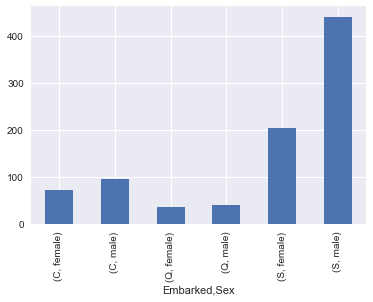

In [223]:
_cross_train.groupby(['Embarked', 'Sex'])['Survived'].count().plot(kind='bar')

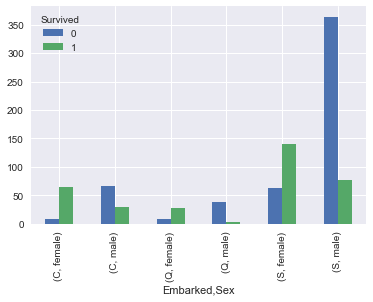

In [227]:
# 個人的にはpivotが見やすい
_cross_train.pivot_table(index=['Embarked', 'Sex'], columns='Survived', values='PassengerId', aggfunc='count').plot(kind='bar')

これはどう解釈すればよい・・・・？

Sで乗った客が多く、男性が多くなくなったため、相関があるっぽい。こういう場合は入れないほうがよい？


In [234]:
# 家族

_cross_train['FamilySize'] = _cross_train['SibSp'] + _cross_train['Parch']
_cross_train['FamilyCategory'] = np.where(_cross_train['FamilySize'] == 0, 'Solo', np.where(_cross_train['FamilySize'] <= 3, 'NuClear', 'Big'))

In [240]:
_cross_train.groupby(['FamilyCategory'], as_index=False)['Survived'].mean()

,FamilyCategory,Survived
0,Big,0.161290
1,NuClear,0.578767
2,Solo,0.303538


In [238]:
_cross_train.groupby(['FamilyCategory', 'Sex'], as_index=False)['Survived'].mean()

,FamilyCategory,Sex,Survived
0,Big,female,0.272727
1,Big,male,0.034483
2,NuClear,female,0.806452
3,NuClear,male,0.321168
4,Solo,female,0.785714
5,Solo,male,0.155718


In [239]:
_cross_train.groupby(['FamilyCategory', 'Sex'], as_index=False)['Survived'].count()

,FamilyCategory,Sex,Survived
0,Big,female,33
1,Big,male,29
2,NuClear,female,155
3,NuClear,male,137
4,Solo,female,126
5,Solo,male,411
